# Effect size (Cohen's d)

The first ingredient in a power analysis is **effect size**. 

Power analysis determines the sample size needed to detect an effect of a certain size.

What is **effect size**? It is a measure of whether the effect (difference of means, correlation) of interest is big or small, *relative to the random noise or variability in the data*.

In this notebook we look at the effect size for the $t$-test and for Pearson's correlation. We will see that:

* The effect size for the $t$-test is Cohen's $d$, where

$$ d = \frac{\bar{x_1}-\bar{x_2}}{s} $$

* The effect size for Pearson's correlation is simply the correlation coefficient, $r$

## Video

Here is a video explaining the idea of effect size for:
* difference of means (Cohen's $d$)
* correlation (Spearman's $r$)

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/-KArntUcuys?si=cLeSnhcL7lycqtDj" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [3]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings 
warnings.simplefilter('ignore', category=FutureWarning)

## Effect size for the $t$-test

**Example:**

A researcher hypothesises that geography students are taller than psychology students.

$\mathcal{H_o}:$ The mean heights of psychology ($\mu_p$) and geography ($\mu_g$) students are the same; $\mu_p = \mu_g$

$\mathcal{H_a}:$ The mean heights of geography students is greater than the mean height of psychology students; $\mu_g > \mu_p$


He measures the heights of 12 geography students an 10 psychology students, which are given in the dataframe below:

In [4]:
heights=pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/PsyGeogHeights.csv')
heights

studentID     subject  height
0      186640  psychology   154.0
1      588140  psychology   156.3
2      977390  psychology   165.6
3      948470  psychology   162.0
4      564360  psychology   162.0
5      604180  psychology   159.0
6      770760  psychology   166.1
7      559170  psychology   165.9
8      213240  psychology   163.7
9      660220  psychology   165.6
10     311550  psychology   163.1
11     249170  psychology   176.6
12     139690   geography   171.6
13     636160   geography   171.5
14     649650   geography   154.6
15     595280   geography   162.6
16     772880   geography   164.4
17     174880   geography   168.6
18     767580   geography   175.3
19     688870   geography   168.4
20     723650   geography   183.5
21     445960   geography   164.1

Let's calculate the sample mean for each subject group:

In [2]:
heights.groupby('subject').height.mean()

NameError: name 'heights' is not defined

So the Geography students are about 5cm taller than the Psychology students.

Is this a large difference? Would it be obvious in a psychology-geography student party who is a psychology student and who is a geography student, just from their heights? 

We can visualise how much the populations overlap by plotting them:

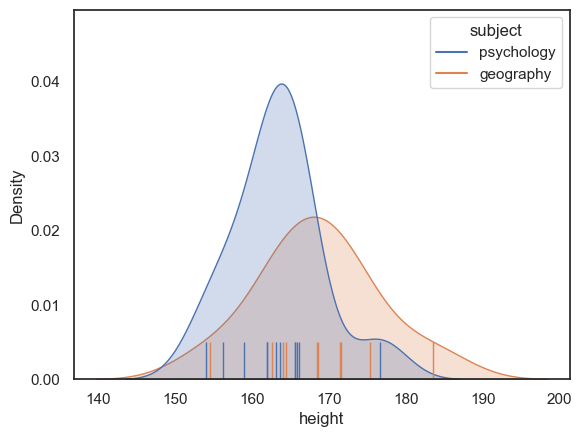

In [73]:
# plot KDEs
sns.kdeplot(data=heights, x='height', hue='subject', fill=True)
sns.rugplot(data=heights, x='height', hue='subject', height=0.1)

plt.show()

Hm, no, we probably could not tell who is a psychology student and who is a geography student, just from their heights, but it looks like there is a difference between the groups overall.

### Effect size $\neq$ statistical significance 

We could ask if there is a statistically signifiant difference between the groups by running a $t$-test:

In [74]:
stats.ttest_ind(heights.query('subject=="geography"').height,
                heights.query('subject=="psychology"').height, 
                alternative='greater')

Ttest_indResult(statistic=1.7743564827449236, pvalue=0.04561467878556142)

The difference is *just* significant at $\alpha$=0.05 - our $p$-value is 0.0456

**However**, this doesn't really tell us whether the effect is big (whether we could easily spot a tall geography student at a Psychosoc party), because the value of $t$ also depends on the sample size, $n$. To illustrate this, consider the following sample `heights2`, which is ten times larger (120 psychology students and 100 geography students), but with the same mean and sd in each group as the small ($n$ = 12,10) sample:

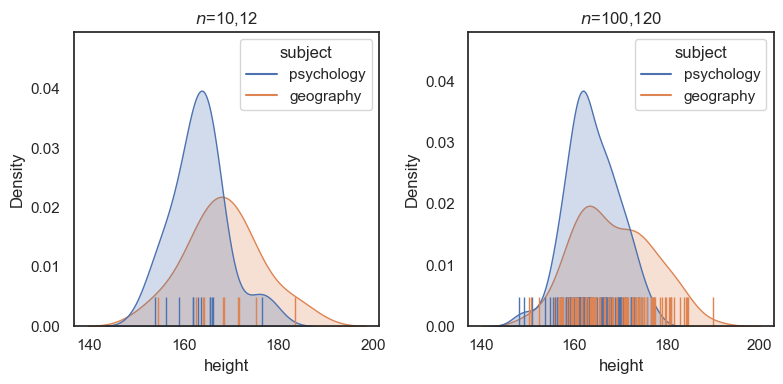

In [75]:
heights2 = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/heightsLargerSample.csv')

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('$n$=10,12')
sns.kdeplot(data=heights, x='height', hue='subject', fill=True)
sns.rugplot(data=heights, x='height', hue='subject', height=0.1)

plt.subplot(1,2,2)
plt.title('$n$=100,120')
sns.kdeplot(data=heights2, x='height', hue='subject', fill=True)
sns.rugplot(data=heights2, x='height', hue='subject', height=0.1)

plt.tight_layout()
plt.show()

Although the mean and sd for each group are about the same, if we conduct a $t$-test on the larger dataset, we find the difference is *much* more significant

In [76]:
# small sample size
stats.ttest_ind(heights.query('subject=="geography"').height,
                heights.query('subject=="psychology"').height, 
                alternative='greater')

Ttest_indResult(statistic=1.7743564827449236, pvalue=0.04561467878556142)

In [77]:
# large sample size
stats.ttest_ind(heights2.query('subject=="geography"').height,
                heights2.query('subject=="psychology"').height, 
                alternative='greater')

Ttest_indResult(statistic=4.770032273659233, pvalue=1.6851503676180654e-06)

**Conclusion** the $t$-test cannot tell us whether the effect of subject studied on height is large or small - for this we need a 'pure' measure of the size of the difference relative to variability, regardless of $n$

## Variance matters for effect size

Is a 5cm difference in height between psychology and geography students a big effect? How easily could we spot a tall geographer gatecrashing the Psychosoc party?

This will depend on both the difference in mean heights, and the standard deviation (variablity) within each group.

Consider the following dataset which has the same difference in means, but now much less variability within each group:

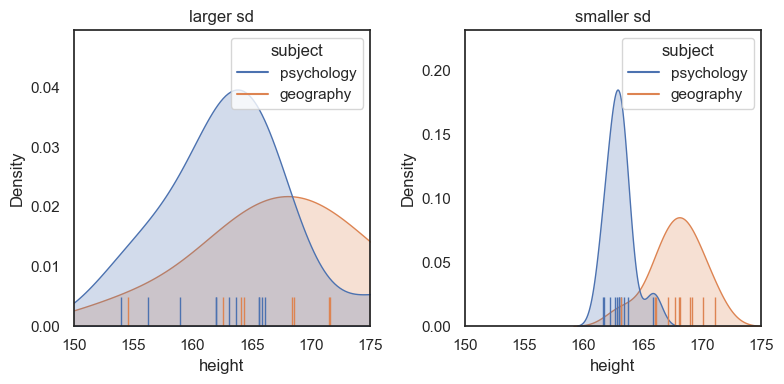

In [78]:
heights3 = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/heightsSmallerSD.csv')

plt.figure(figsize=(8,4))
# plot KDEs
plt.subplot(1,2,1)
plt.title('larger sd')
sns.kdeplot(data=heights, x='height', hue='subject', fill=True)
sns.rugplot(data=heights, x='height', hue='subject', height=0.1)
plt.xlim([150,175])

plt.subplot(1,2,2)
plt.title('smaller sd')
sns.kdeplot(data=heights3, x='height', hue='subject', fill=True)
sns.rugplot(data=heights3, x='height', hue='subject', height=0.1)
plt.xlim([150,175])

plt.tight_layout()
plt.show()

For the dataset on the right (lower sd within each group) we can see a much clearer separation between the psychology and geography students - in practical terms, it would be easier to guess a person's subject based on their height.

The plot on the right has a **larger effect size**, as we shall see in the next section

## Cohen's $d$

We quantify the effect size for the difference of means as Cohen's $d$:

$$ d = \frac{\bar{x_g}-\bar{x_p}}{s} $$

where:
* $\bar{x_g}$ is the mean height of our sample of geography students
* $\bar{x_p}$ is the mean height of our sample of psychology students
* $s$ is the *shared standard deviation estimate* basaed on the standard deviations of the samples, $s_p$ and $s_g$:

$$ s = \sqrt{\frac{(n_p-1)s_p^2 + (n_g-1)s_g^2)}{n_p + n_g - 2}} $$

oof! The *shared variance (or sd) estimate*, $s$, is just a way of getting a single 'average' standard deviation measure when we have two sample standard deviations for our two groups, and is actually part of the equation from the independent samples $t$-test.

$$t = \frac{\bar{x_1}-\bar{x_2}}{s\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}}$$

Let's implement that:

In [80]:
# calculate shared standard deviation s

xP = heights.query('subject=="psychology"').height.mean()
xG = heights.query('subject=="geography"').height.mean()

sP = heights.query('subject=="psychology"').height.std()
sG = heights.query('subject=="geography"').height.std()

nP = heights.query('subject=="psychology"').height.count()
nG = heights.query('subject=="geography"').height.count()

s=(((nP-1)*(sP**2) + (nG-1)*(sG**2))/(nP+nG-2))**0.5 # **0.5 means 'to the power of a half' ie square root
s

6.758944074335872

$s$ is an estimate of the standard deviation of heights, based on both groups, so it should be similar to the standard deviation of each of the individual groups.

Now we can calculate our effect size:

In [35]:
# Cohen's d
d=(xG-xP)/s
d

0.7597340566106963

So $d=0.76$, ie the difference in mean heights between psychology and geography students is 0.76 standard deviations.

### Effect size is a *standardized* measure

Note that in dividing the difference by the standard deviations, we are quantifying the overlap between the two distributions **independent of the data values themselves.**

Therefore it is possible to have quite different datasets with the same effect size - for example if the difference of means and the standard deviations both increase, effect size may stay the same.

For example, here I have created another dataset with the same effect size $d=0.760$, comparing the weights of (fictional) black and grey sheep:

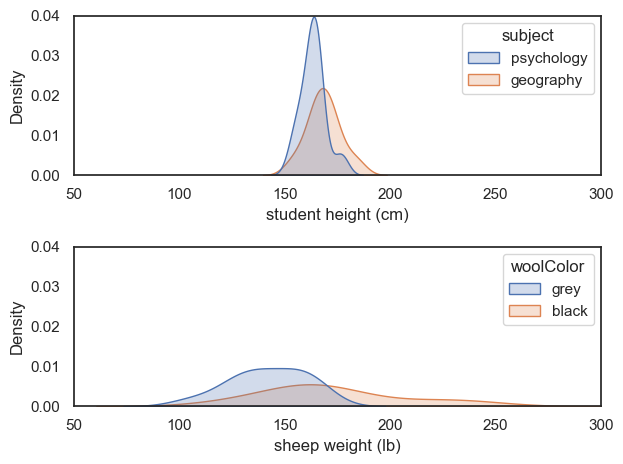

In [25]:
sheep=pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/SheepWeights.csv')

# plot KDEs for psy/geog heights
plt.subplot(2,1,1)
sns.kdeplot(data=heights, x='height', hue='subject', fill=True)
plt.xlabel('student height (cm)')
plt.xlim([50,300])
plt.ylim([0,0.04])

# plot KDEs for black/grey sheep weights
plt.subplot(2,1,2)
sns.kdeplot(data=sheep, x='weight', hue='woolColor', fill=True)
plt.xlabel('sheep weight (lb)')
plt.xlim([50,300])
plt.ylim([0,0.04])

plt.tight_layout()
plt.show()

Although the 'sheep' data are much more spread out, the difference of means between groups is also larger. 

These two different datasets therefore have the same effect size, which quantifies the *overlap* between groups (psychology and geography students, or black and grey sheep)

### Small, medium and large effects

Cohen himself defined small medium and large effects as follows:

* $d=0.2$: small effect
* $d=0.5$: medium effect
* $d=0.8$: large effect

stating that *"a medium effect of 0.5 is visible to the naked eye of a careful observer"*

This is what the effect sizes look like for normally distributed data:
    
<img src="https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/images/Chp8_EffectSize
.png" width=95% >


Of course, even tiny differences are "visible to the naked eye" for these smooth curves; in contrast, for real data, there will be uncertainty about how well some fitted curve (KDE plot) really represents the underlying population - hence to ascertain our confidence in the difference (statistical significance), we must consider the sample size $n$ as well as effect size.

## Recovering $d$ from $t$

Most published papers do not report effect sizes or Cohen's $d$ for $t$-tests

However, they do report $t$ values and sample sizes. 

$d$ can be recovered relatively simply from $t$ and $n$ - the formulae for this (for the paired and unpaired t-test) are given in the page **Determining effect size**

This is important as we often need to use the effect size from a published study to *estimate* the effect size in a study we are planning, and thus select the correct sample size via power analysis. This process will be explored later in this chapter.